In [49]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
from collections import OrderedDict
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import math
from time import time
%matplotlib inline

### Setup

In [8]:
# use nvidia gpu if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# only float32 tested
dtype = torch.float32
    
print("Device:", device)
print("Data type:", dtype)

Device: cpu
Data type: torch.float32


### Define Encoder/Decoder Logic

In [3]:
class L2Norm(nn.Module):
    """L2Norm model class -- a layer class for normalizing a matrix of vectors
    
    Args:
        dim (int) - which dimension to normalize along. 0 for column vectors, 1 for row vectors
    """
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        
        self.dim=dim
        
    def forward(self,input):
        return nn.functional.normalize(input, p=2, dim=self.dim)

In [4]:
class Hamiltonian(nn.Module):
    """Hamiltonian -- a class used to help learn physically relevant sub-manifold
    
    Args:
        H - the hamiltonian matrix in the original basis
        N (int) - the size of the original basis
        N_proj (int) - the size of the projected basis
    """
    
    def __init__(self, H, N, N_proj):

        super(Hamiltonian, self).__init__()
        
        # initialize the class variables
        self.H = H
        self.N = N
        self.N_proj = N_proj
        self.eye = torch.eye(N_proj, device=device, dtype=dtype)
        
        # initialize the encoder and decoder architectures
        self.decoder = nn.Sequential(OrderedDict([('matmul', nn.Linear(self.N_proj, self.N, bias=False)),
                                                  ('normalize', L2Norm())
                                                  ]))

    # return the current cost matrix
    def forward(self):
        M = self.decoder(self.eye)
        return M @ self.H @ M.t(), M @ M.t()

In [5]:
class Cost():
    """Cost class -- used to calculate goodness of projection map for optimization purposes
    
    Args:
        N_proj - number of basis states in the projected space
        alpha (float) - the weight of the orthogonality cost relative to the energy cost (units of energy)
    """
    
    def __init__(self, N_proj, alpha):
        super(Cost, self).__init__()
        
        self.N_proj = N_proj
        self.eye = torch.eye(N_proj, device=device, dtype=dtype)
        self.sorter = torch.tensor([[1/(i+1)/(j+1) for i in range(self.N_proj)] for j in range(self.N_proj)], device=device, dtype=dtype)
        
    def __call__(self, Hproj, Iproj):
        cost_matrix = (Hproj*self.sorter)**2 + alpha * (Iproj - self.eye)**2
        return cost_matrix.sum()/self.N_proj**2

### Synthesize a reasonable test Hamiltonian

In [6]:
def generate_H(N, N_proj):
    eigs,_ = (torch.rand(N, device=device, dtype=dtype)*N).sort()
    Hgen_proj = torch.diag(eigs)
    Wgen = torch.tensor(ortho_group.rvs(N), device=device, dtype=dtype)
    
    Hgen = Wgen @ Hgen_proj @ Wgen.t()
    
    return Hgen, Wgen, eigs

In [7]:
# Hamiltonian Setup
N=500
N_proj=30
alpha=1

In [8]:
Hgen, Wgen, eigs = generate_H(N, N_proj)
print ("eigs:", eigs[:N_proj])

eigs: tensor([ 1.4541,  2.6655,  2.8721,  3.5421,  3.8253,  4.6797,  5.1546,  6.3272,
         6.7771,  7.3475,  7.9243,  9.6975, 11.7525, 12.6057, 13.2221, 16.3810,
        16.8727, 18.8439, 19.3214, 20.3303, 21.4008, 21.4098, 21.5786, 22.2389,
        22.4583, 22.6910, 22.9431, 23.2577, 23.3700, 26.2989], device='cuda:0')


In [9]:
%time torch.symeig(Hgen, eigenvectors=True).eigenvalues[:N_proj]

CPU times: user 1.24 s, sys: 285 ms, total: 1.52 s
Wall time: 543 ms


tensor([ 1.4541,  2.6655,  2.8721,  3.5420,  3.8253,  4.6797,  5.1546,  6.3271,
         6.7771,  7.3478,  7.9242,  9.6974, 11.7524, 12.6057, 13.2221, 16.3809,
        16.8726, 18.8438, 19.3213, 20.3303, 21.4008, 21.4098, 21.5785, 22.2390,
        22.4583, 22.6910, 22.9430, 23.2577, 23.3699, 26.2989], device='cuda:0')

In [10]:
# the hamiltonian model
model = Hamiltonian(Hgen, N, N_proj).to(device=device)

In [11]:
# loss function and optimizer
criterion = Cost(N_proj, alpha)
optimizer = optim.Rprop(model.parameters(), lr=0.1)

### Synthesize a physical Hamiltonian: two particles in a ring of length 1 (identical to a ring with a delta barrier)

In [92]:
def physical_H(basis_size,g): # g for interaction strength, it is better if the basis_size is an odd number 
    H_data = g*np.ones((basis_size,basis_size)) # potential energy
    H_diag=np.zeros(basis_size)
    
    for i in range(basis_size):
        H_diag[i]= (2*math.pi*int(((i+1)/2)//1))**2 # kinetic energy E=k^2; k=2 Pi n, n=0,\pm1 , \pm 2,...
    
    H_phys =  torch.tensor(H_data+np.diag(H_diag),device=device, dtype=dtype)
    
    return H_phys


In [94]:
basis_size=7
g=2

physical_H(basis_size,g)



tensor([[  2.0000,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000],
        [  2.0000,  41.4784,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000],
        [  2.0000,   2.0000,  41.4784,   2.0000,   2.0000,   2.0000,   2.0000],
        [  2.0000,   2.0000,   2.0000, 159.9137,   2.0000,   2.0000,   2.0000],
        [  2.0000,   2.0000,   2.0000,   2.0000, 159.9137,   2.0000,   2.0000],
        [  2.0000,   2.0000,   2.0000,   2.0000,   2.0000, 357.3058,   2.0000],
        [  2.0000,   2.0000,   2.0000,   2.0000,   2.0000,   2.0000, 357.3058]])

### Optimization

In [12]:
def early_stop(errs, rel_tol, patience=2):
    stop=True
    for i in range(patience):
        rel_change = np.abs((errs[-(i+1)] - errs[-(i+2)]) / errs[-(i+1)])
        stop = stop and rel_change < rel_tol
    return stop

def optimize(n_iter, n_save, show_progress=True, stop_early=True, rel_tol=0.01, patience=2):
    model.decoder.matmul.reset_parameters()
    running_loss= 0
    start_time = time()
    
    # store progress every n_save iters
    j=0
    its = []
    errs = []
    Hps = []
    Ips = []
    ts = []
    
    # iterate
    for i in range(n_iter):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        Hp, Ip = model()
        loss = criterion(Hp, Ip)
        loss.backward()
        optimizer.step()

        # print /save statistics
        running_loss += loss.item()
        if i % n_save == 0:
            # save progress
            its.append(i)
            errs.append(running_loss)
            Hps.append(Hp)
            Ips.append(Ip)
            ts.append(time() - start_time)
            
            # print progress 
            if show_progress:
                change = errs[j]-errs[j-1] if j>0 else 0
                print('[%d] loss: %.8f. diff: %.8f. time: %.4f' % (i + 1, running_loss / 10, change, ts[-1]))
            
            if j>=patience and stop_early and early_stop(errs, rel_tol, patience):
                print("Early stopping criteria met.")
                break
            
            running_loss = 0.0
            j+=1
            

    print('Finished Training')
    return its, errs, Hps, Ips, ts

In [13]:
# Test
n_iter=1000
n_print=1
its, errs, hps, ips, ts = optimize(n_iter, n_print, stop_early=True, rel_tol=0.001, patience=3, show_progress=False)

Early stopping criteria met.
Finished Training


In [14]:
# # hproj progress
# vmax=eigs[:N_proj].abs().max()
# vmin=0
# for it, hp in zip(its,hps):
#     Hplt = hp.cpu().detach().numpy()
#     plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)
#     plt.title("iter: %i" % (it+1))
#     plt.colorbar()
#     plt.show()

### Make an animation

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


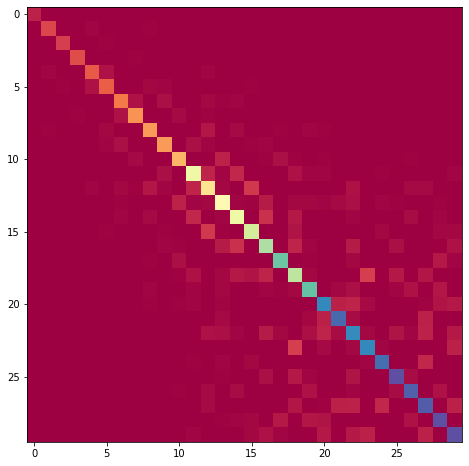

In [15]:
fig = plt.figure()
fig.set_size_inches(8,8, True)
ax = plt.axes()
vmax=eigs[:N_proj].abs().max()
vmin=0
Hplt = hps[0].cpu().detach().numpy()
mat = plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)


def init():
    mat.set_data(hps[0].cpu().detach().numpy())
    return mat,
def animate(i):
    hp = hps[i].cpu().detach().numpy()
    mat.set_data(hp)
    return mat,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(hps), interval=60, blit=True)


anim.save('diagonalization.gif', writer='imagemagick')